# Model with GPT architecture for classification spam massages

In thise approach I've wrote same architecture as in GPT-2 model in order to take trained weights from Open AI and use them with slassification head ontop of GPT model in order to make a classification prediction.

In [222]:
import os
import urllib.request
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path
import time
from tqdm import tqdm
import importlib

import matplotlib.pyplot as plt

import tiktoken

import GPT_manual_architecture as GPT_model

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sns

#Thise is my .py file with whole GPT architecture
import GPT_manual_architecture as GPT_model

#File for downloading weights and load them into model
from download_wights import download_and_load_gpt2, load_weights_into_gpt

#File for creating Dataloaders
import Dataset_dataloader as Loader

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [4]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

In [71]:
target_names = df["Label"].unique()
num_classes = df["Label"].nunique()


In [48]:
def plot_lable(df):
    label_counts = df['Label'].value_counts()
    fig, ax = plt.subplots(figsize=(8,6))
    wedges, texts, autotexts = ax.pie(label_counts, autopct='%1.1f%%', startangle=90)
    
    ax.axis('equal')
    ax.set_title('Proportion of Labels in Train Dataset')
    ax.legend(wedges, target_names, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.show()

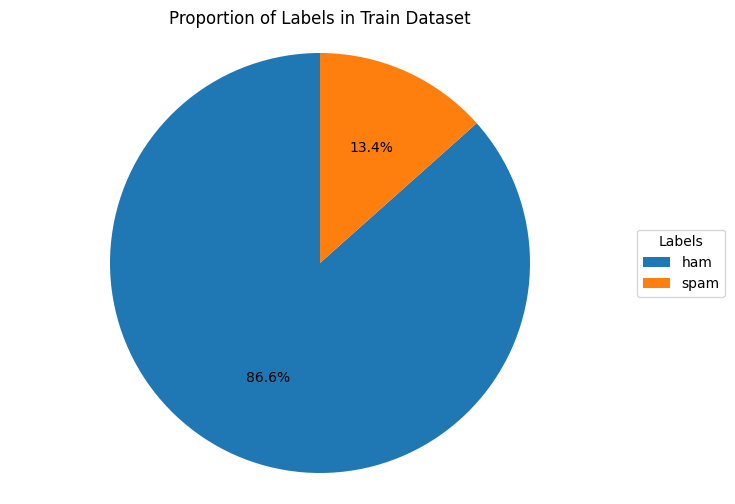

In [6]:
plot_lable(df)

In [7]:
df[df["Label"] == "spam"]

,Label,Text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [8]:
tokenizer = tiktoken.get_encoding("gpt2")

In [9]:
CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [10]:
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [12]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


## Agmentation spam by generating new text after traing model

In [84]:
spam_df = df[df["Label"]=="spam"]["Text"]

In [86]:
train_loader = Loader.create_dataloader_v1(
    tokenizer,
    spam_df,
    batch_size=2,
    max_length=BASE_CONFIG["context_length"],
    stride=BASE_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
    proc_type = "generate_next_word"
)

In [16]:
augment_model = GPT_model.GPTModel(BASE_CONFIG)
load_weights_into_gpt(augment_model, params)

In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss
    
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [18]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

In [19]:
augment_model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

In [20]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [21]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=50256):
    batch_size = idx.size(0)
    finished = torch.zeros(batch_size, dtype=torch.bool, device=idx.device)  # Tracks which sequences are done

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]  # only use last time step

        # Apply top-k filtering
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(1)
            logits = torch.where(logits < min_val, torch.full_like(logits, float('-inf')), logits)

        # Temperature sampling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Update finished sequences
        if eos_id is not None:
            eos_hit = (idx_next == eos_id).squeeze(1)  # (batch,)
            finished = finished | eos_hit  # mark sequences as finished
            if finished.all():
                break  # All sequences have finished

        # Append tokens
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [22]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor
    
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [23]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size,
            top_k=25,
            temperature=1.4
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # decoded_text = decoded_text.split("<|endoftext|>")[0]
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [24]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()  # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [40]:
start_time = time.time()

augment_model.to(device)
optimizer = torch.optim.AdamW(augment_model.parameters(), lr=0.001, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    augment_model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Congrats!", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 7.987, Val loss 7.929
Ep 1 (Step 000005): Train loss 5.188, Val loss 5.037
Ep 1 (Step 000010): Train loss 4.509, Val loss 4.319
Congrats! 1st attempt will get your cash txts, your complimentary colour camera. £350.50
Ep 2 (Step 000015): Train loss 3.895, Val loss 3.968
Ep 2 (Step 000020): Train loss 3.397, Val loss 3.259
Ep 2 (Step 000025): Train loss 3.028, Val loss 2.793
Congrats! 1st week free T&Cs Rply POLYPHONICALLY AWARD! Only 10p per message: Rply shrgxxy420giftk11/10pm-stop. PoBox398x.
Ep 3 (Step 000030): Train loss 2.476, Val loss 2.544
Ep 3 (Step 000035): Train loss 2.148, Val loss 1.977
Ep 3 (Step 000040): Train loss 1.812, Val loss 1.668
Congrats! Uptown Admirer! 1Winaweed!Age16 -18/MobsmoreFrmMob.shp 4 more
Ep 4 (Step 000045): Train loss 1.437, Val loss 1.552
Ep 4 (Step 000050): Train loss 1.102, Val loss 1.119
Ep 4 (Step 000055): Train loss 1.020, Val loss 1.053
Congrats!Win the latest Ringtone from 2004!SKY OPT OUT 08701418720201 PO BOX 3W4

In [41]:
torch.save(augment_model.state_dict(), "model_for_augmentation.pth")

In [26]:
if os.path.exists("model_for_augmentation.pth"):
    augment_model.load_state_dict(torch.load("model_for_augmentation.pth"))
    augment_model.to("cpu")
    augment_model.eval()

/var/folders/tr/8w0nm2r933q2n7ws8zrfc_n40000gn/T/ipykernel_23976/1047902958.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  augment_model.load_state_dict(torch.load("mod

In [45]:
token_ids = generate(
    model=augment_model,
    idx=text_to_token_ids("Congrats", tokenizer),
    max_new_tokens=70,
    context_size=BASE_CONFIG["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Congrats 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! 


In [37]:
num_aumented_texts = len(df[df["Label"] == df["Label"].unique()[0]]) - len(df[df["Label"] == df["Label"].unique()[1]])

In [98]:
data = []
starting_words = list(set(spam_df.str.split().str[0].tolist()))
for _ in tqdm(range(num_aumented_texts), desc="Text"):
    import random
    start_word = random.choice(starting_words)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(start_word, tokenizer),
        max_new_tokens=70,
        context_size=BASE_CONFIG["context_length"],
        top_k=25,
        temperature=2
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    data.append({"Text": generated_text, "Label": "spam"})

# Convert to DataFrame
df_augmented = pd.DataFrame(data)            

Text: 100%|██████████| 4078/4078 [48:15<00:00,  1.41it/s]  


In [ ]:
df_combined = pd.concat([df, df_augmented], ignore_index=True)

In [ ]:
df_combined.to_csv("augmented_df.csv", index=False)

In [46]:
df_augm = pd.read_csv("augmented_df.csv")

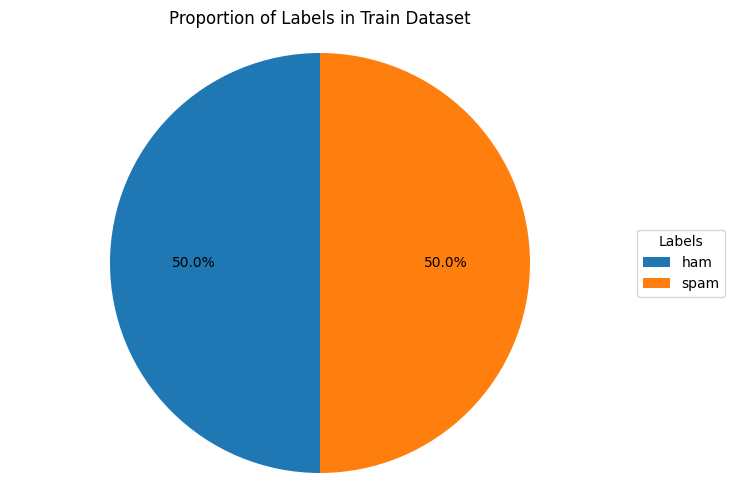

In [49]:
plot_lable(df_augm)

## Train classification model on balanced dataset

In [60]:
importlib.reload(Loader)

<module 'Dataset_dataloader' from '/Users/sergeiakhmadulin/My Drive/LLM/Dataset_dataloader.py'>

In [90]:
df_augm["Label"] = df_augm["Label"].map({"ham": 0, "spam": 1})

In [91]:
def random_split(df, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    # Calculate split indices

    train_end = int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:]

    return train_df, validation_df
    
train_df, test_df = random_split(df_augm, 0.2)

In [92]:
train_class_loader = Loader.create_dataloader_v1(
    tokenizer,
    train_df,
    batch_size=8,
    max_length=BASE_CONFIG["context_length"],
    stride=BASE_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
    proc_type="classification"
)

test_class_loader = Loader.create_dataloader_v1(
    tokenizer,
    test_df,
    batch_size=8,
    max_length=BASE_CONFIG["context_length"],
    stride=BASE_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
    proc_type="classification"
)

In [67]:
model_class = GPT_model.GPTModel(BASE_CONFIG)
load_weights_into_gpt(model_class, params)
model_class.eval();

In [72]:
for param in model_class.parameters():
    param.requires_grad = False

model_class.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [74]:
for param in model_class.trf_blocks[-1:].parameters():
    param.requires_grad = True

for param in model_class.final_norm.parameters():
    param.requires_grad = True

In [76]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [78]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")
        for input_batch, target_batch in progress_bar:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=None)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=None)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [131]:
model_class.to(device)

num_epochs = 5
optimizer = torch.optim.AdamW(model_class.parameters(), lr=5e-5, weight_decay=0.1)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
        model_class, train_class_loader, test_class_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5
    )

Training Epoch 1/5: 100%|██████████| 241/241 [01:09<00:00,  3.47it/s]


Training accuracy: 96.99% | Validation accuracy: 95.12%


Training Epoch 2/5: 100%|██████████| 241/241 [01:09<00:00,  3.47it/s]


Training accuracy: 97.15% | Validation accuracy: 95.23%


Training Epoch 3/5: 100%|██████████| 241/241 [01:12<00:00,  3.32it/s]


Training accuracy: 97.04% | Validation accuracy: 95.01%


Training Epoch 4/5: 100%|██████████| 241/241 [06:23<00:00,  1.59s/it]


Training accuracy: 97.04% | Validation accuracy: 94.79%


Training Epoch 5/5: 100%|██████████| 241/241 [01:09<00:00,  3.44it/s]


Training accuracy: 97.98% | Validation accuracy: 95.98%


In [133]:
torch.save(model_class.state_dict(), "model_for_classification.pth")

In [204]:
def make_predictions(model, df, batch_size = None, num_examples = None, pad_token_id = 50256):
    if num_examples == "All":
        batch_data = df
        if batch_size == None:
            batch_size = 8
    else:
        if batch_size == None or batch_size > num_examples:
            batch_size = num_examples
        data_spam = df_augm[df["Label"] == 1].sample(num_examples)
        data_nospam = df_augm[df["Label"] == 0].sample(num_examples)
        batch_data = pd.concat([data_spam,data_nospam], ignore_index = True)

    encoded_texts = [
                tokenizer.encode(text) for text in batch_data["Text"]
            ]
    
    max_length = 0
    for encoded_text in encoded_texts:
        encoded_length = len(encoded_text)
        if encoded_length > max_length:
            max_length = encoded_length
    
                
    encoded_texts = [
            encoded_text[:max_length]
            for encoded_text in encoded_texts
        ]
    
    encoded_texts = [
                encoded_text + [pad_token_id] * (max_length - len(encoded_text))
                for encoded_text in encoded_texts
            ]
    pred_list = []
    for i in tqdm(range(0, len(encoded_texts), batch_size), desc="Processing Batches"):
        input_tensor = torch.tensor(encoded_texts[i:i+batch_size], device=device)

        with torch.no_grad():
            logits = model(input_tensor)[:, -1, :]
        
        predictions = torch.argmax(logits, dim=-1)
        pred_list.extend(predictions.cpu().numpy())

    batch_data.loc[:, "pred"] = pred_list

    return batch_data[["Text", "Label", "pred"]]

In [218]:
df_with_pred = make_predictions(model_class, test_df, batch_size = None, num_examples = "All")

Processing Batches: 100%|██████████| 965/965 [04:09<00:00,  3.87it/s]


In [219]:
df_with_pred.head()

,Text,Label,pred
1930,Freemsg: GO to 82480 now! 150p/text. BT-nation...,1,1
1931,Are you this much buzy,0,0
1932,"FROM4u, TC15 92H. Bcm box403303Winawk! age16 t...",1,1
1933,RGENT! !!! kickst txting deck sms. Gold Cup fi...,1,1
1934,Or ü go buy wif him then i meet ü later can?,0,0


In [211]:
def plot_confusion_matrix(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    
    # Set plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

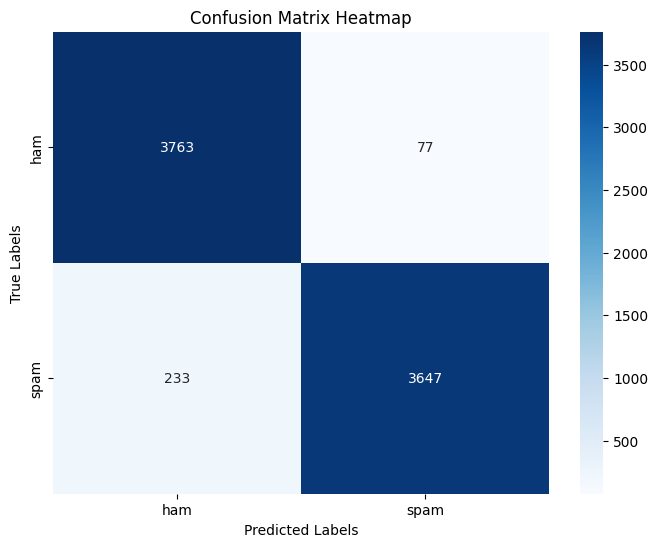

In [220]:
plot_confusion_matrix(df_with_pred["Label"], df_with_pred["pred"])

In [221]:
print(classification_report(df_with_pred["Label"], df_with_pred["pred"]))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3840
           1       0.98      0.94      0.96      3880

    accuracy                           0.96      7720
   macro avg       0.96      0.96      0.96      7720
weighted avg       0.96      0.96      0.96      7720



In [216]:
accuracy_score(df_with_pred["Label"], df_with_pred["pred"])

0.9636269430051814